In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 126096
New cases registered today: 5485
New cases registered today in %: 4.55
Doubling time in the last five days: 16.7
Doubling time yesterday: 17.2
Trend of new cases (in %) in the last 5 days: 23.09


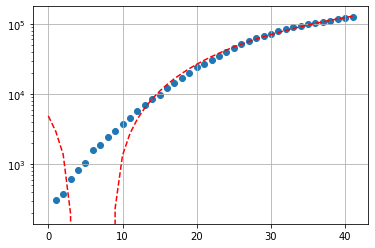

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1703
New cases registered today: 75
New cases registered today in %: 4.61
Doubling time in the last five days: 17.8
Doubling time yesterday: 18.1
Trend of new cases (in %) in the last 5 days: 21.56


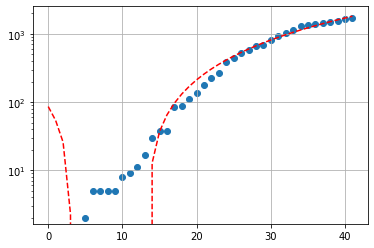

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.8351
Total cases up to today: 325
New cases registered today: 8
New cases registered today in %: 2.52
Doubling time in the last five days: 23.3
Doubling time yesterday: 23.2
Trend of new cases (in %) in the last 5 days: 16.07


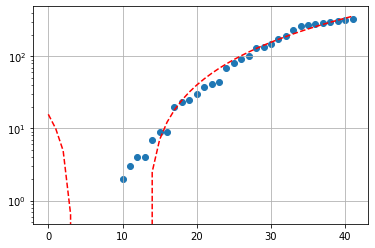

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.5929
Total cases up to today: 179
New cases registered today: 5
New cases registered today in %: 2.87
Doubling time in the last five days: 9.2
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 45.53


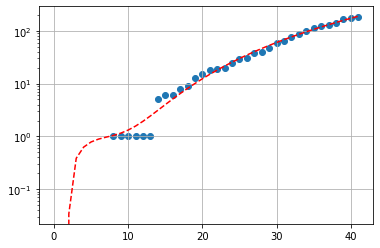

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 2.2626
Total cases up to today: 727
New cases registered today: 27
New cases registered today in %: 3.86
Doubling time in the last five days: 22.2
Doubling time yesterday: 21.1
Trend of new cases (in %) in the last 5 days: 16.88


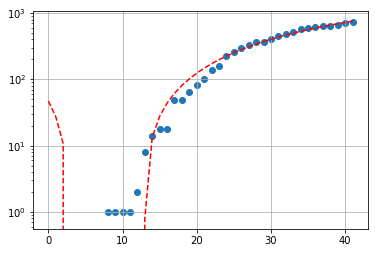

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.5233
Total cases up to today: 472
New cases registered today: 35
New cases registered today in %: 8.01
Doubling time in the last five days: 15.2
Doubling time yesterday: 18.7
Trend of new cases (in %) in the last 5 days: 25.53


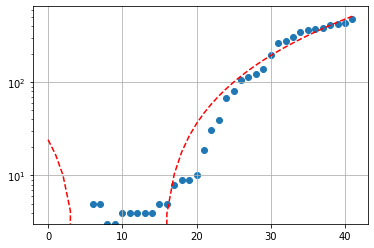

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 278
New cases registered today: 14
New cases registered today in %: 5.3
Doubling time in the last five days: 16.7
Doubling time yesterday: 16.5
Trend of new cases (in %) in the last 5 days: 23.01


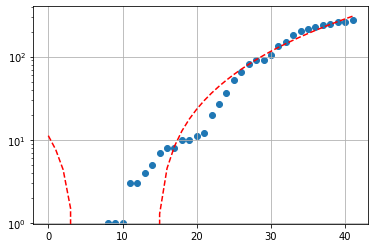

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.6811
Total cases up to today: 136
New cases registered today: 11
New cases registered today in %: 8.8
Doubling time in the last five days: 12.9
Doubling time yesterday: 11.3
Trend of new cases (in %) in the last 5 days: 30.77


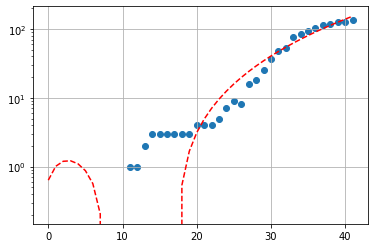

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.3831
Total cases up to today: 142
New cases registered today: 3
New cases registered today in %: 2.16
Doubling time in the last five days: 22.8
Doubling time yesterday: 26.6
Trend of new cases (in %) in the last 5 days: 16.39


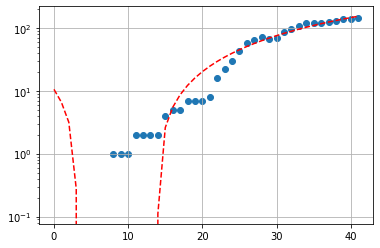

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1644
New cases registered today: 52
New cases registered today in %: 3.27
Doubling time in the last five days: 19.1
Doubling time yesterday: 18.9
Trend of new cases (in %) in the last 5 days: 19.91


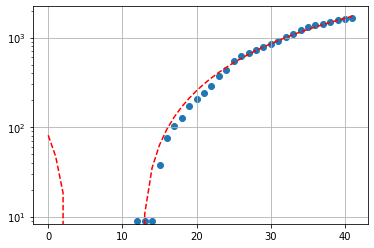

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 793
New cases registered today: 54
New cases registered today in %: 7.31
Doubling time in the last five days: 18.4
Doubling time yesterday: 25.5
Trend of new cases (in %) in the last 5 days: 20.7


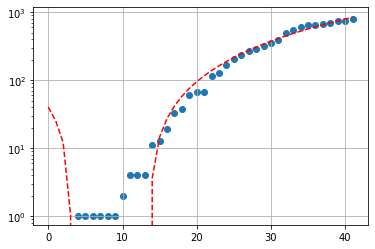

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.4333
Total cases up to today: 157
New cases registered today: 7
New cases registered today in %: 4.67
Doubling time in the last five days: 28.5
Doubling time yesterday: 30.7
Trend of new cases (in %) in the last 5 days: 12.95


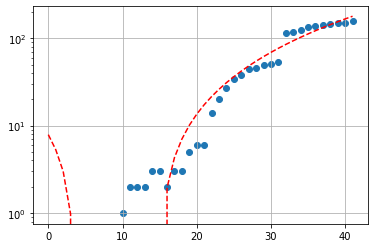

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.3232
Total cases up to today: 230
New cases registered today: 26
New cases registered today in %: 12.75
Doubling time in the last five days: 16.3
Doubling time yesterday: 33.6
Trend of new cases (in %) in the last 5 days: 23.66


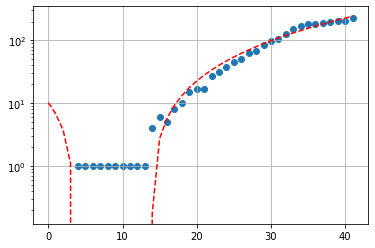

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.6208
Total cases up to today: 109
New cases registered today: 3
New cases registered today in %: 2.83
Doubling time in the last five days: 21.8
Doubling time yesterday: 26.5
Trend of new cases (in %) in the last 5 days: 17.2


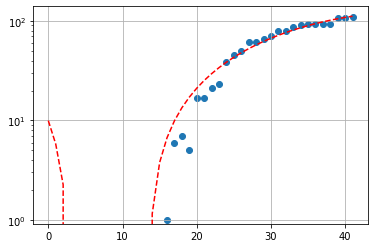

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.4279
Total cases up to today: 237
New cases registered today: 15
New cases registered today in %: 6.76
Doubling time in the last five days: 17.8
Doubling time yesterday: 22.3
Trend of new cases (in %) in the last 5 days: 21.54


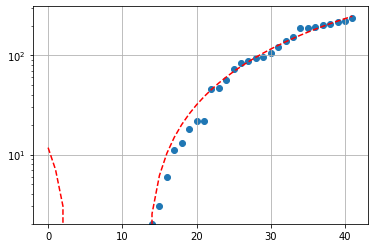

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.3712
Total cases up to today: 60
New cases registered today: 3
New cases registered today in %: 5.26
Doubling time in the last five days: 11.2
Doubling time yesterday: 13.4
Trend of new cases (in %) in the last 5 days: 36.36


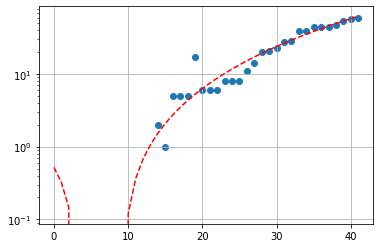

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 2732
New cases registered today: 92
New cases registered today in %: 3.48
Doubling time in the last five days: 9.8
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 42.51


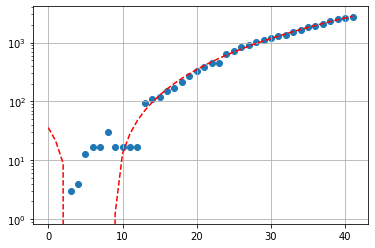

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.8382
Total cases up to today: 355
New cases registered today: 4
New cases registered today in %: 1.14
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 57.08


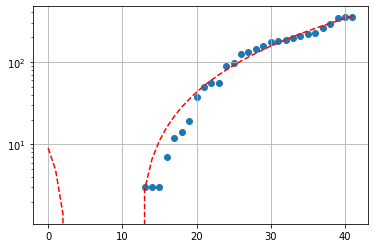

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.3862
Total cases up to today: 108
New cases registered today: 22
New cases registered today in %: 25.58
Doubling time in the last five days: 9.9
Doubling time yesterday: 16.8
Trend of new cases (in %) in the last 5 days: 42.11


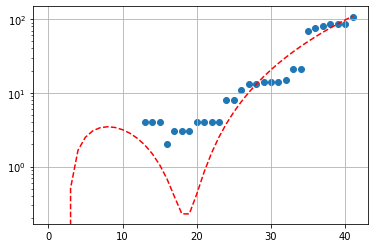

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.3246
Total cases up to today: 300
New cases registered today: 21
New cases registered today in %: 7.53
Doubling time in the last five days: 11.3
Doubling time yesterday: 11.4
Trend of new cases (in %) in the last 5 days: 35.75


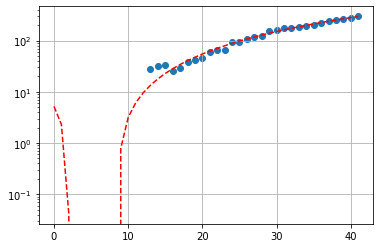

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.4931
Total cases up to today: 1532
New cases registered today: 34
New cases registered today in %: 2.27
Doubling time in the last five days: 9.2
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 45.49


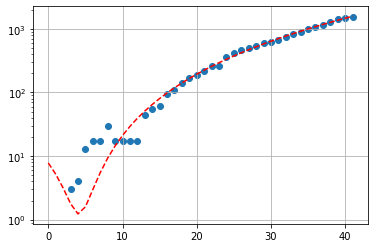

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.3956
Total cases up to today: 437
New cases registered today: 11
New cases registered today in %: 2.58
Doubling time in the last five days: 14.0
Doubling time yesterday: 15.0
Trend of new cases (in %) in the last 5 days: 28.15


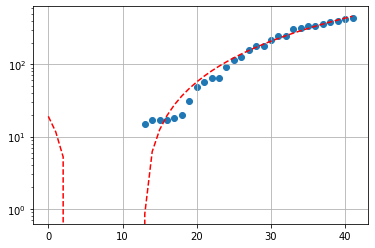

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


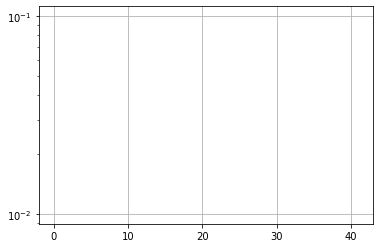

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 2.498
Total cases up to today: 2521
New cases registered today: 92
New cases registered today in %: 3.79
Doubling time in the last five days: 13.2
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 29.95


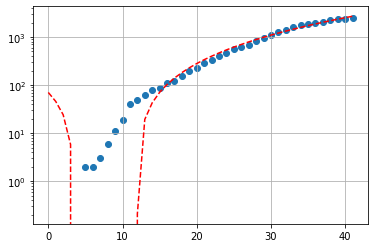

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 1.4008
Total cases up to today: 488
New cases registered today: 14
New cases registered today in %: 2.95
Doubling time in the last five days: 8.2
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 52.5


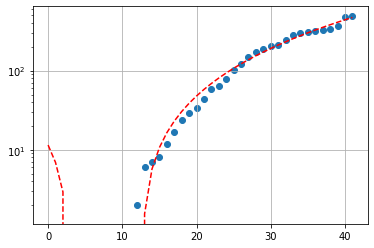

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 3.7226
Total cases up to today: 2609
New cases registered today: 58
New cases registered today in %: 2.27
Doubling time in the last five days: 21.6
Doubling time yesterday: 19.6
Trend of new cases (in %) in the last 5 days: 17.42


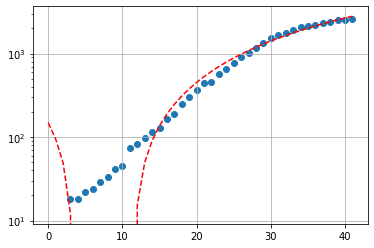

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 5.068
Total cases up to today: 2275
New cases registered today: 74
New cases registered today in %: 3.36
Doubling time in the last five days: 21.3
Doubling time yesterday: 20.5
Trend of new cases (in %) in the last 5 days: 17.69


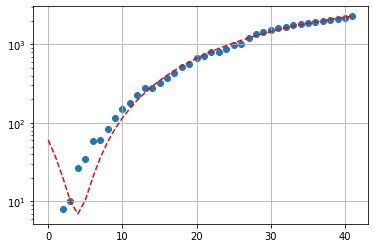

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 10.0852
Total cases up to today: 2892
New cases registered today: 50
New cases registered today in %: 1.76
Doubling time in the last five days: 37.2
Doubling time yesterday: 28.4
Trend of new cases (in %) in the last 5 days: 9.75


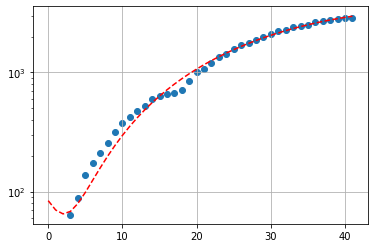

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.8088
Total cases up to today: 708
New cases registered today: 20
New cases registered today in %: 2.91
Doubling time in the last five days: 17.4
Doubling time yesterday: 18.1
Trend of new cases (in %) in the last 5 days: 22.07


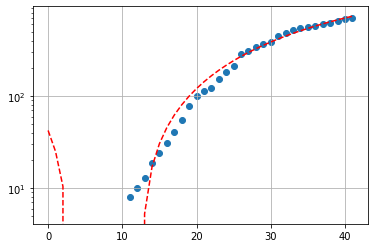

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 5.7579
Total cases up to today: 3066
New cases registered today: 158
New cases registered today in %: 5.43
Doubling time in the last five days: 12.2
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 32.9


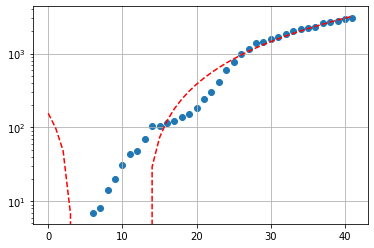

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.6112
Total cases up to today: 1553
New cases registered today: 30
New cases registered today in %: 1.97
Doubling time in the last five days: 35.1
Doubling time yesterday: 35.7
Trend of new cases (in %) in the last 5 days: 10.38


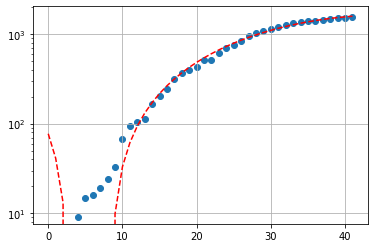

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 2042
New cases registered today: 61
New cases registered today in %: 3.08
Doubling time in the last five days: 13.6
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 28.91


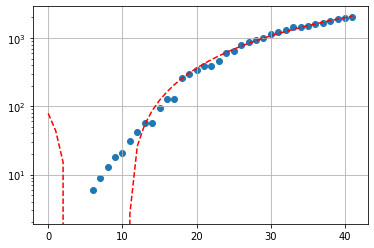

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.8305
Total cases up to today: 116
New cases registered today: 1
New cases registered today in %: 0.87
Doubling time in the last five days: 20.6
Doubling time yesterday: 14.8
Trend of new cases (in %) in the last 5 days: 18.37


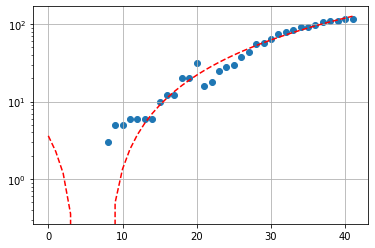

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.5062
Total cases up to today: 470
New cases registered today: 9
New cases registered today in %: 1.95
Doubling time in the last five days: 23.3
Doubling time yesterday: 18.7
Trend of new cases (in %) in the last 5 days: 16.05


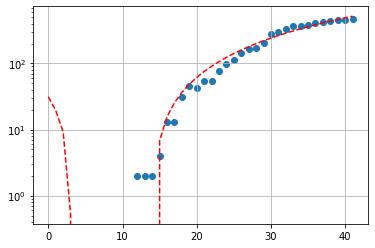

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.8549
Total cases up to today: 670
New cases registered today: 19
New cases registered today in %: 2.92
Doubling time in the last five days: 16.8
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 22.94


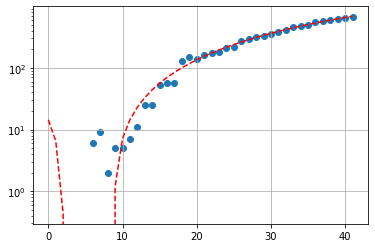

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.4789
Total cases up to today: 786
New cases registered today: 32
New cases registered today in %: 4.24
Doubling time in the last five days: 9.1
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 46.64


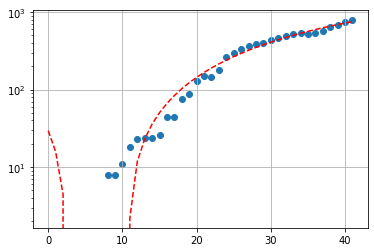

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 3851
New cases registered today: 121
New cases registered today in %: 3.24
Doubling time in the last five days: 15.4
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 25.15


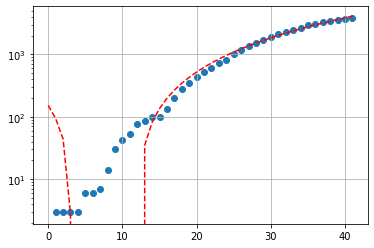

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.7484
Total cases up to today: 369
New cases registered today: 5
New cases registered today in %: 1.37
Doubling time in the last five days: 24.9
Doubling time yesterday: 15.2
Trend of new cases (in %) in the last 5 days: 14.95


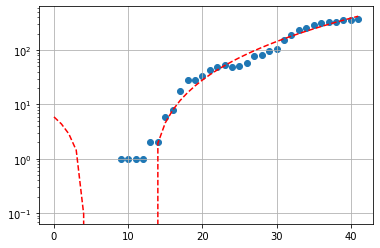

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.5845
Total cases up to today: 336
New cases registered today: 18
New cases registered today in %: 5.66
Doubling time in the last five days: 12.9
Doubling time yesterday: 15.4
Trend of new cases (in %) in the last 5 days: 30.74


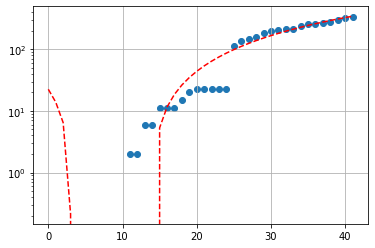

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.2006
Total cases up to today: 189
New cases registered today: 1
New cases registered today in %: 0.53
Doubling time in the last five days: 9.7
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 43.18


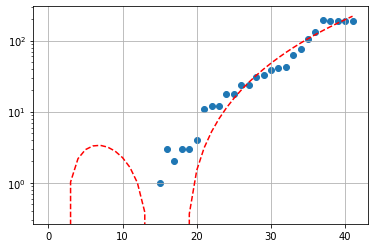

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.6234
Total cases up to today: 2714
New cases registered today: 94
New cases registered today in %: 3.59
Doubling time in the last five days: 16.0
Doubling time yesterday: 14.6
Trend of new cases (in %) in the last 5 days: 24.15


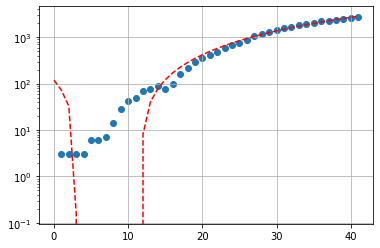

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.7617
Total cases up to today: 243
New cases registered today: 3
New cases registered today in %: 1.25
Doubling time in the last five days: 11.8
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 34.25


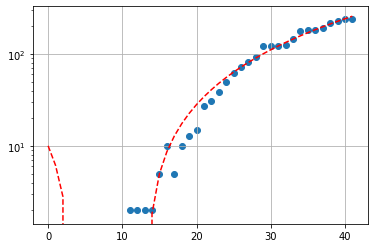

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 3689
New cases registered today: 1551
New cases registered today in %: 72.54
Doubling time in the last five days: 4.9
Doubling time yesterday: 19.8
Trend of new cases (in %) in the last 5 days: 102.03


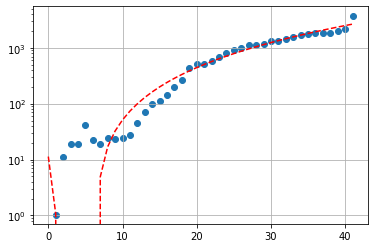

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 2.2633
Total cases up to today: 1924
New cases registered today: 612
New cases registered today in %: 46.65
Doubling time in the last five days: 6.1
Doubling time yesterday: 16.9
Trend of new cases (in %) in the last 5 days: 75.71


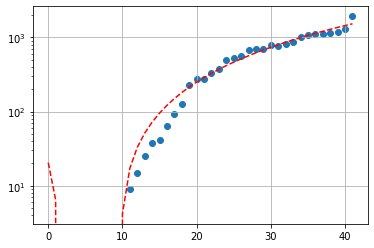

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 2.7239
Total cases up to today: 586
New cases registered today: 362
New cases registered today in %: 161.61
Doubling time in the last five days: 3.8
Doubling time yesterday: -42.6
Trend of new cases (in %) in the last 5 days: 150.43


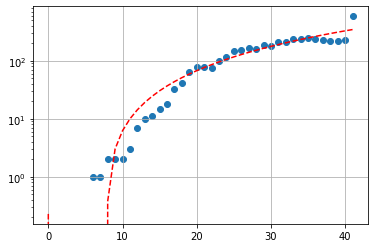

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 2.0163
Total cases up to today: 445
New cases registered today: 104
New cases registered today in %: 30.5
Doubling time in the last five days: 5.9
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 79.44


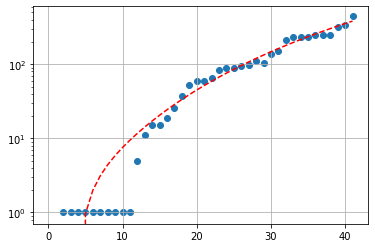

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 2.627
Total cases up to today: 734
New cases registered today: 473
New cases registered today in %: 181.23
Doubling time in the last five days: 3.2
Doubling time yesterday: 73.6
Trend of new cases (in %) in the last 5 days: 194.78


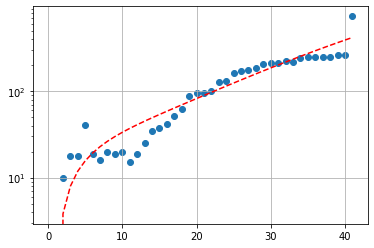

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 49323
New cases registered today: 1271
New cases registered today in %: 2.65
Doubling time in the last five days: 22.5
Doubling time yesterday: 22.7
Trend of new cases (in %) in the last 5 days: 16.65


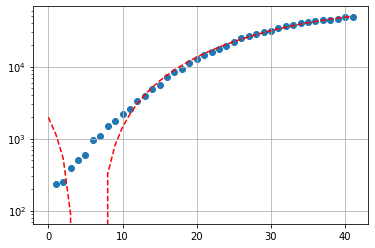

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 8.7501
Total cases up to today: 9712
New cases registered today: 124
New cases registered today in %: 1.29
Doubling time in the last five days: 35.3
Doubling time yesterday: 34.2
Trend of new cases (in %) in the last 5 days: 10.33


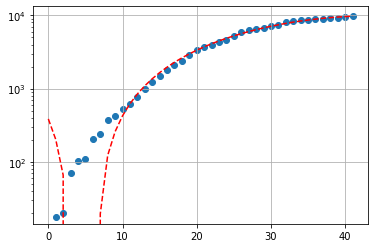

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 7.3991
Total cases up to today: 9340
New cases registered today: 160
New cases registered today in %: 1.74
Doubling time in the last five days: 31.5
Doubling time yesterday: 31.1
Trend of new cases (in %) in the last 5 days: 11.63


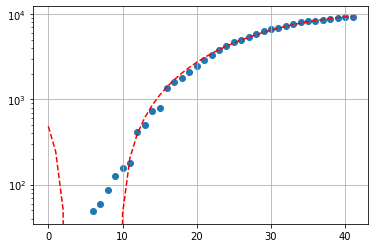

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 2.3059
Total cases up to today: 1384
New cases registered today: 65
New cases registered today in %: 4.93
Doubling time in the last five days: 15.2
Doubling time yesterday: 15.9
Trend of new cases (in %) in the last 5 days: 25.7


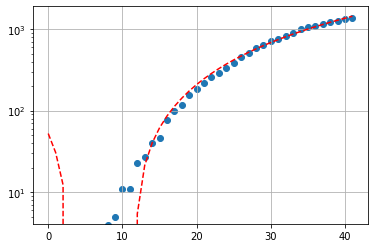

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 11.7784
Total cases up to today: 4233
New cases registered today: 79
New cases registered today in %: 1.9
Doubling time in the last five days: 38.5
Doubling time yesterday: 37.6
Trend of new cases (in %) in the last 5 days: 9.41


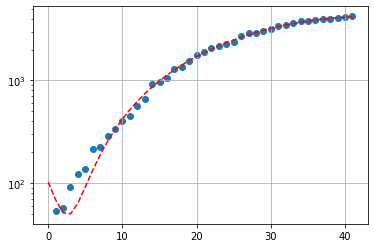

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.9464
Total cases up to today: 1678
New cases registered today: 50
New cases registered today in %: 3.07
Doubling time in the last five days: 26.2
Doubling time yesterday: 27.8
Trend of new cases (in %) in the last 5 days: 14.15


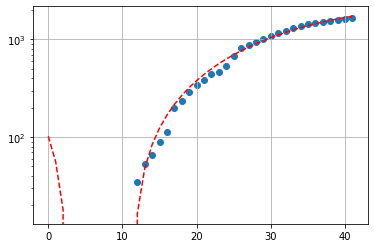

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 9.8326
Total cases up to today: 2255
New cases registered today: 17
New cases registered today in %: 0.76
Doubling time in the last five days: 54.5
Doubling time yesterday: 49.6
Trend of new cases (in %) in the last 5 days: 6.57


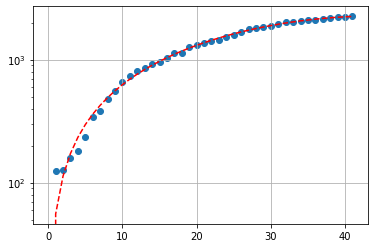

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 4.9538
Total cases up to today: 2044
New cases registered today: 63
New cases registered today in %: 3.18
Doubling time in the last five days: 18.1
Doubling time yesterday: 17.1
Trend of new cases (in %) in the last 5 days: 21.09


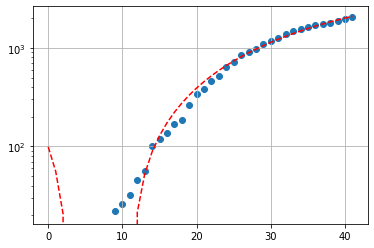

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 3.4895
Total cases up to today: 11230
New cases registered today: 411
New cases registered today in %: 3.8
Doubling time in the last five days: 15.0
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 26.02


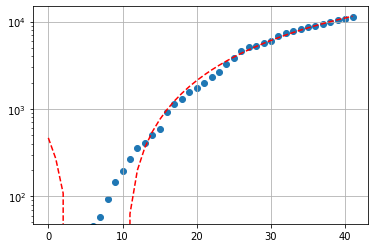

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 3.5057
Total cases up to today: 3046
New cases registered today: 111
New cases registered today in %: 3.78
Doubling time in the last five days: 16.3
Doubling time yesterday: 16.0
Trend of new cases (in %) in the last 5 days: 23.72


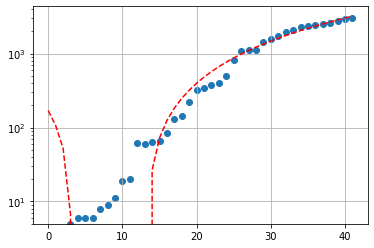

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 4.7857
Total cases up to today: 2619
New cases registered today: 120
New cases registered today in %: 4.8
Doubling time in the last five days: 16.9
Doubling time yesterday: 16.9
Trend of new cases (in %) in the last 5 days: 22.78


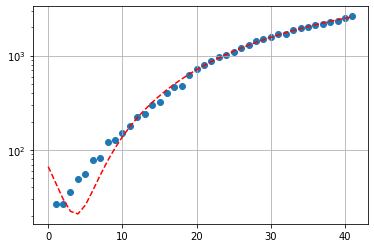

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 3.2573
Total cases up to today: 591
New cases registered today: 28
New cases registered today in %: 4.97
Doubling time in the last five days: 15.1
Doubling time yesterday: 14.9
Trend of new cases (in %) in the last 5 days: 25.74


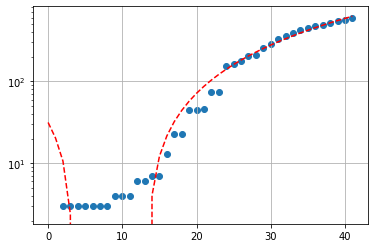

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.3381
Total cases up to today: 1191
New cases registered today: 43
New cases registered today in %: 3.75
Doubling time in the last five days: 12.0
Doubling time yesterday: 12.3
Trend of new cases (in %) in the last 5 days: 33.37


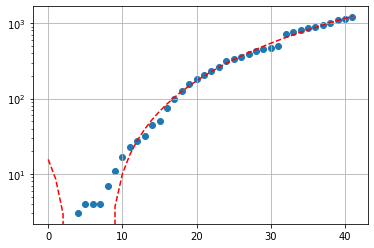

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 4366
New cases registered today: 120
New cases registered today in %: 2.83
Doubling time in the last five days: 22.9
Doubling time yesterday: 21.7
Trend of new cases (in %) in the last 5 days: 16.3


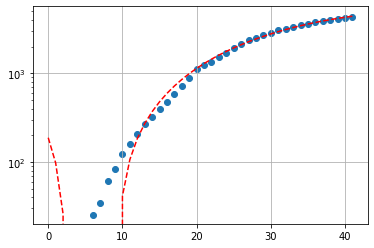

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.86
Total cases up to today: 1356
New cases registered today: 66
New cases registered today in %: 5.12
Doubling time in the last five days: 17.8
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 21.51


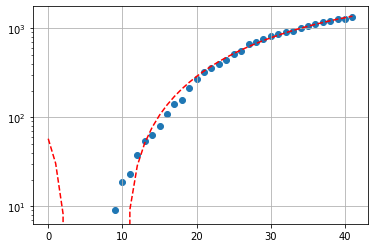

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.122
Total cases up to today: 235
New cases registered today: 2
New cases registered today in %: 0.86
Doubling time in the last five days: 60.9
Doubling time yesterday: 20.6
Trend of new cases (in %) in the last 5 days: 5.86


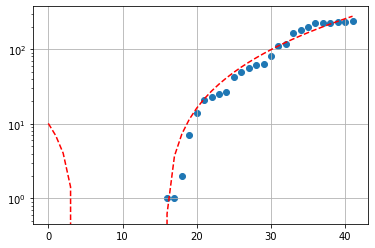

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.7615
Total cases up to today: 308
New cases registered today: 3
New cases registered today in %: 0.98
Doubling time in the last five days: 20.0
Doubling time yesterday: 16.1
Trend of new cases (in %) in the last 5 days: 18.92


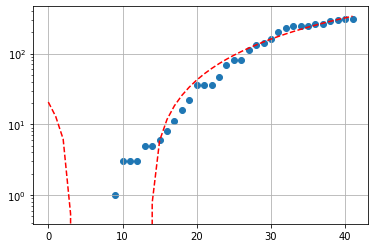

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.9252
Total cases up to today: 614
New cases registered today: 16
New cases registered today in %: 2.68
Doubling time in the last five days: 15.8
Doubling time yesterday: 15.3
Trend of new cases (in %) in the last 5 days: 24.54


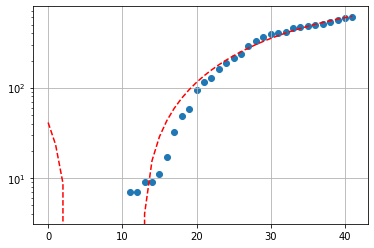

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 5.1371
Total cases up to today: 1853
New cases registered today: 33
New cases registered today in %: 1.81
Doubling time in the last five days: 32.2
Doubling time yesterday: 33.1
Trend of new cases (in %) in the last 5 days: 11.36


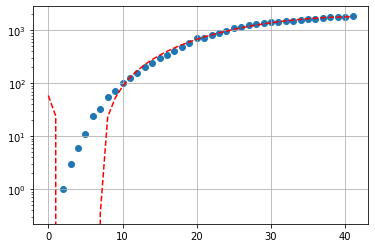

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 210
New cases registered today: 16
New cases registered today in %: 8.25
Doubling time in the last five days: 7.6
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 57.89


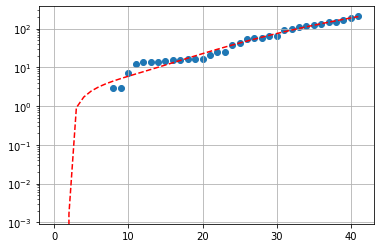

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.7389
Total cases up to today: 166
New cases registered today: 12
New cases registered today in %: 7.79
Doubling time in the last five days: 11.9
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 33.87


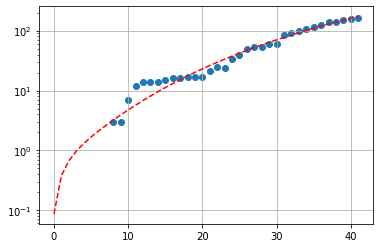

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.5128
Total cases up to today: 44
New cases registered today: 4
New cases registered today in %: 10.0
Doubling time in the last five days: 2.2
Doubling time yesterday: 2.3
Trend of new cases (in %) in the last 5 days: 388.89


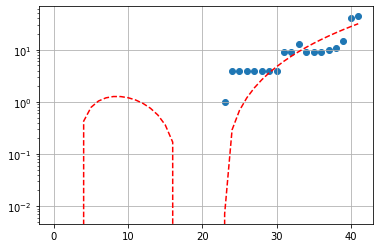

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 12133
New cases registered today: 634
New cases registered today in %: 5.51
Doubling time in the last five days: 12.0
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 33.48


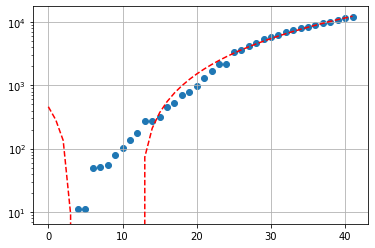

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 4.1321
Total cases up to today: 1763
New cases registered today: 172
New cases registered today in %: 10.81
Doubling time in the last five days: 11.9
Doubling time yesterday: 15.9
Trend of new cases (in %) in the last 5 days: 33.86


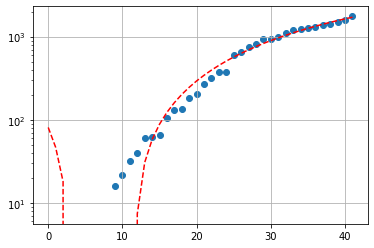

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 2.7506
Total cases up to today: 596
New cases registered today: 36
New cases registered today in %: 6.43
Doubling time in the last five days: 10.9
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 37.33


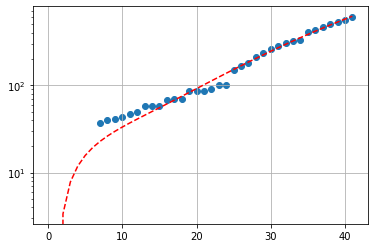

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 3.198
Total cases up to today: 571
New cases registered today: 12
New cases registered today in %: 2.15
Doubling time in the last five days: 22.7
Doubling time yesterday: 20.2
Trend of new cases (in %) in the last 5 days: 16.53


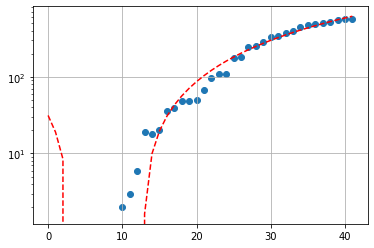

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.818
Total cases up to today: 1071
New cases registered today: 139
New cases registered today in %: 14.91
Doubling time in the last five days: 9.1
Doubling time yesterday: 9.6
Trend of new cases (in %) in the last 5 days: 46.51


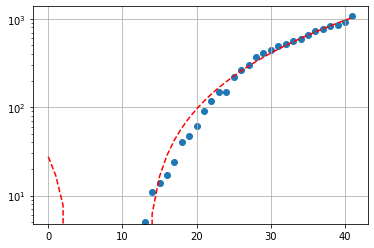

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 2.6638
Total cases up to today: 986
New cases registered today: 19
New cases registered today in %: 1.96
Doubling time in the last five days: 16.3
Doubling time yesterday: 12.5
Trend of new cases (in %) in the last 5 days: 23.71


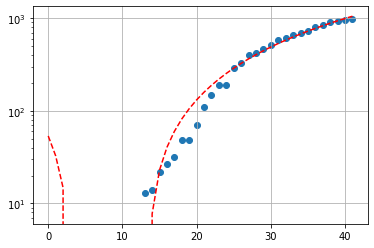

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 2.6275
Total cases up to today: 5985
New cases registered today: 213
New cases registered today in %: 3.69
Doubling time in the last five days: 11.7
Doubling time yesterday: 10.5
Trend of new cases (in %) in the last 5 days: 34.34


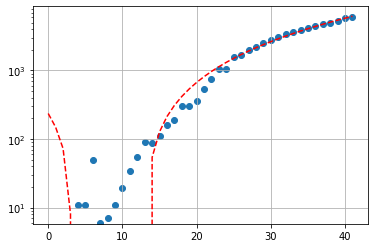

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 3.4823
Total cases up to today: 556
New cases registered today: 21
New cases registered today in %: 3.93
Doubling time in the last five days: 10.0
Doubling time yesterday: 9.8
Trend of new cases (in %) in the last 5 days: 41.48


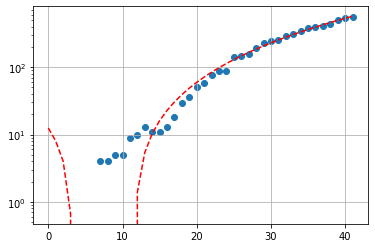

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 3.4797
Total cases up to today: 605
New cases registered today: 22
New cases registered today in %: 3.77
Doubling time in the last five days: 14.1
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 27.91


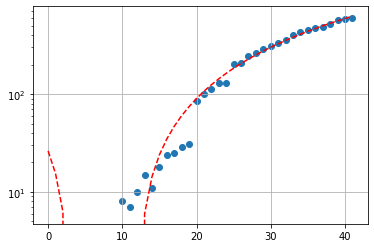

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 2288
New cases registered today: 75
New cases registered today in %: 3.39
Doubling time in the last five days: 13.7
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 28.76


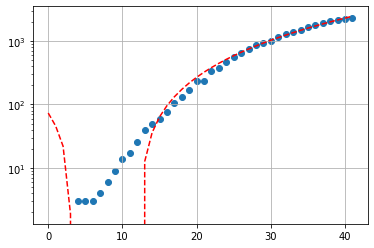

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.6269
Total cases up to today: 790
New cases registered today: 28
New cases registered today in %: 3.67
Doubling time in the last five days: 13.9
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 28.25


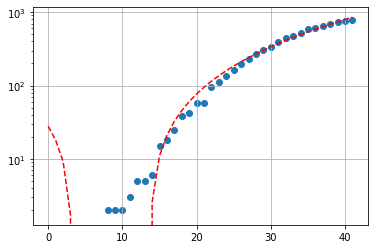

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.3516
Total cases up to today: 138
New cases registered today: 9
New cases registered today in %: 6.98
Doubling time in the last five days: 15.9
Doubling time yesterday: 15.4
Trend of new cases (in %) in the last 5 days: 24.32


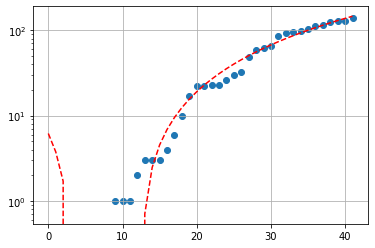

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.6195
Total cases up to today: 246
New cases registered today: 12
New cases registered today in %: 5.13
Doubling time in the last five days: 8.5
Doubling time yesterday: 9.8
Trend of new cases (in %) in the last 5 days: 50.0


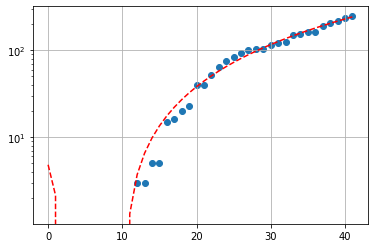

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.8973
Total cases up to today: 564
New cases registered today: 18
New cases registered today in %: 3.3
Doubling time in the last five days: 16.5
Doubling time yesterday: 11.6
Trend of new cases (in %) in the last 5 days: 23.41


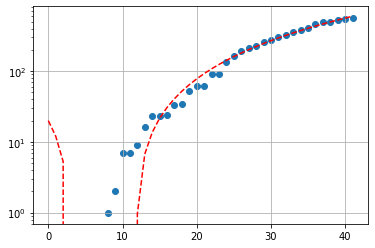

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.4588
Total cases up to today: 368
New cases registered today: 6
New cases registered today in %: 1.66
Doubling time in the last five days: 17.8
Doubling time yesterday: 16.4
Trend of new cases (in %) in the last 5 days: 21.45


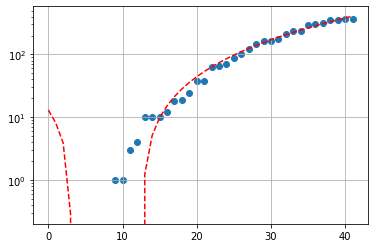

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.3119
Total cases up to today: 182
New cases registered today: 2
New cases registered today in %: 1.11
Doubling time in the last five days: 9.4
Doubling time yesterday: 8.7
Trend of new cases (in %) in the last 5 days: 44.44


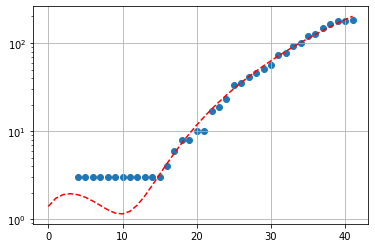

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 907
New cases registered today: 33
New cases registered today in %: 3.78
Doubling time in the last five days: 15.2
Doubling time yesterday: 14.0
Trend of new cases (in %) in the last 5 days: 25.62


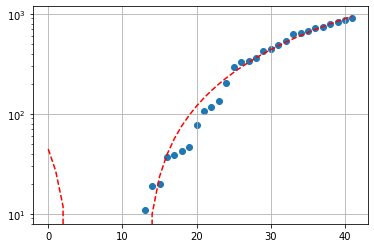

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.2605
Total cases up to today: 146
New cases registered today: 2
New cases registered today in %: 1.39
Doubling time in the last five days: 12.6
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 31.53


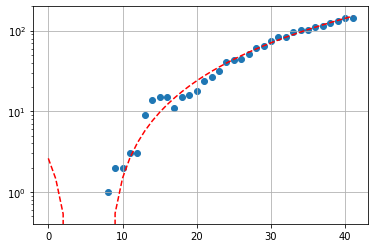

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.4164
Total cases up to today: 65
New cases registered today: 3
New cases registered today in %: 4.84
Doubling time in the last five days: 26.4
Doubling time yesterday: 41.2
Trend of new cases (in %) in the last 5 days: 14.04


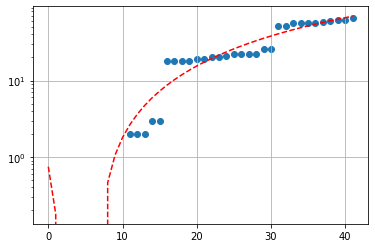

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.1493
Total cases up to today: 24
New cases registered today: 4
New cases registered today in %: 20.0
Doubling time in the last five days: 4.0
Doubling time yesterday: 5.0
Trend of new cases (in %) in the last 5 days: 140.0


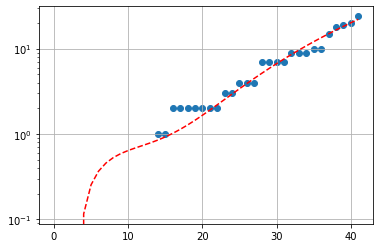

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.8042
Total cases up to today: 601
New cases registered today: 16
New cases registered today in %: 2.74
Doubling time in the last five days: 16.3
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 23.66


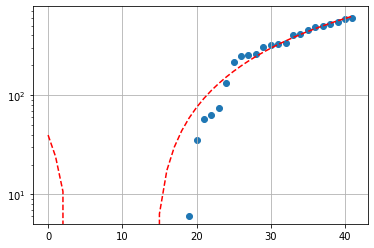

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1994
New cases registered today: 62
New cases registered today in %: 3.21
Doubling time in the last five days: 18.1
Doubling time yesterday: 16.0
Trend of new cases (in %) in the last 5 days: 21.07


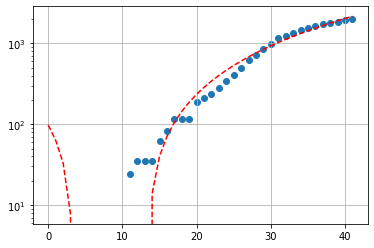

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2421
Total cases up to today: 107
New cases registered today: 5
New cases registered today in %: 4.9
Doubling time in the last five days: 26.8
Doubling time yesterday: 25.4
Trend of new cases (in %) in the last 5 days: 13.83


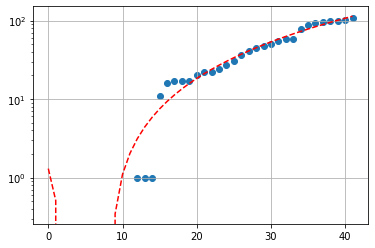

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.3782
Total cases up to today: 102
New cases registered today: 9
New cases registered today in %: 9.68
Doubling time in the last five days: 9.2
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 45.71


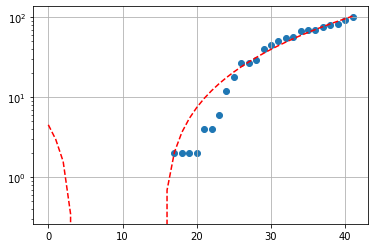

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.5335
Total cases up to today: 594
New cases registered today: 25
New cases registered today in %: 4.39
Doubling time in the last five days: 19.7
Doubling time yesterday: 14.5
Trend of new cases (in %) in the last 5 days: 19.28


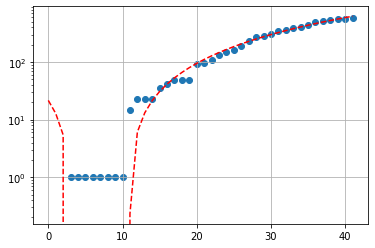

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.69
Total cases up to today: 284
New cases registered today: 4
New cases registered today in %: 1.43
Doubling time in the last five days: 10.3
Doubling time yesterday: 9.6
Trend of new cases (in %) in the last 5 days: 39.9


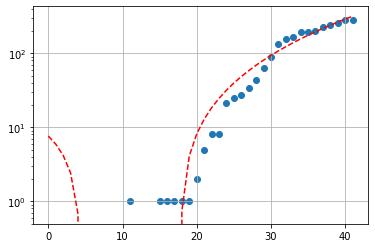

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.5545
Total cases up to today: 353
New cases registered today: 9
New cases registered today in %: 2.62
Doubling time in the last five days: 27.4
Doubling time yesterday: 28.8
Trend of new cases (in %) in the last 5 days: 13.5


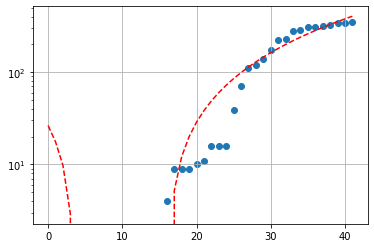

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2358
Total cases up to today: 299
New cases registered today: 3
New cases registered today in %: 1.01
Doubling time in the last five days: 26.2
Doubling time yesterday: 22.1
Trend of new cases (in %) in the last 5 days: 14.12


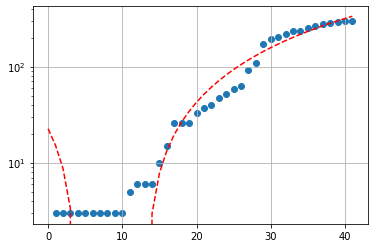

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.1494
Total cases up to today: 48
New cases registered today: 1
New cases registered today in %: 2.13
Doubling time in the last five days: 31.5
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 11.63


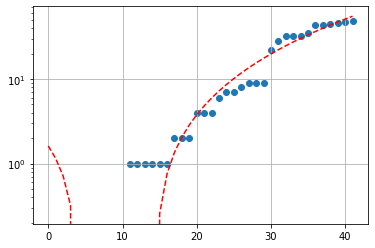

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2706
Total cases up to today: 109
New cases registered today: 2
New cases registered today in %: 1.87
Doubling time in the last five days: 21.8
Doubling time yesterday: 18.8
Trend of new cases (in %) in the last 5 days: 17.2


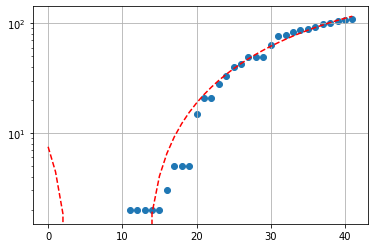

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.2256
Total cases up to today: 98
New cases registered today: 4
New cases registered today in %: 4.26
Doubling time in the last five days: 11.8
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 34.25


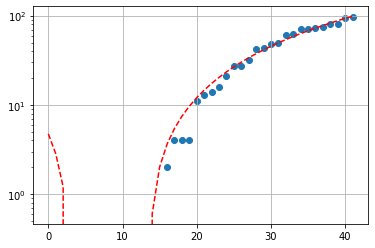

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 5847
New cases registered today: 176
New cases registered today in %: 3.1
Doubling time in the last five days: 14.6
Doubling time yesterday: 13.8
Trend of new cases (in %) in the last 5 days: 26.89


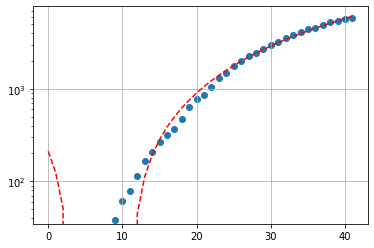

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.0976
Total cases up to today: 378
New cases registered today: 8
New cases registered today in %: 2.16
Doubling time in the last five days: 26.7
Doubling time yesterday: 19.6
Trend of new cases (in %) in the last 5 days: 13.86


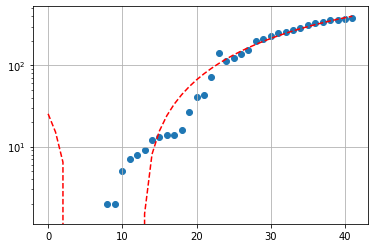

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.6906
Total cases up to today: 1715
New cases registered today: 89
New cases registered today in %: 5.47
Doubling time in the last five days: 7.6
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 57.77


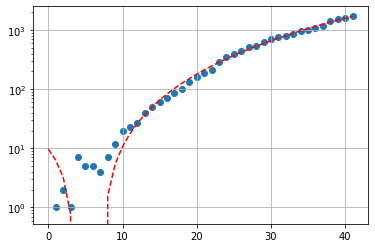

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.2419
Total cases up to today: 277
New cases registered today: 4
New cases registered today in %: 1.47
Doubling time in the last five days: 46.2
Doubling time yesterday: 41.2
Trend of new cases (in %) in the last 5 days: 7.78


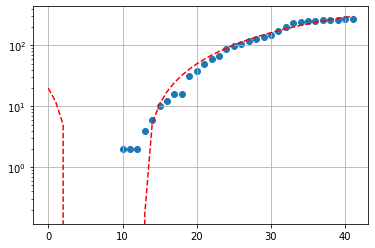

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.9545
Total cases up to today: 322
New cases registered today: 6
New cases registered today in %: 1.9
Doubling time in the last five days: 24.8
Doubling time yesterday: 22.6
Trend of new cases (in %) in the last 5 days: 15.0


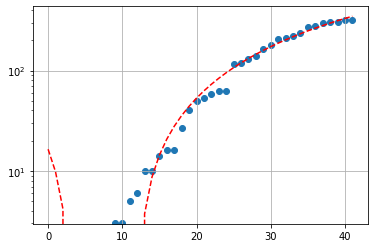

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 2.2357
Total cases up to today: 872
New cases registered today: 17
New cases registered today in %: 1.99
Doubling time in the last five days: 19.3
Doubling time yesterday: 18.8
Trend of new cases (in %) in the last 5 days: 19.62


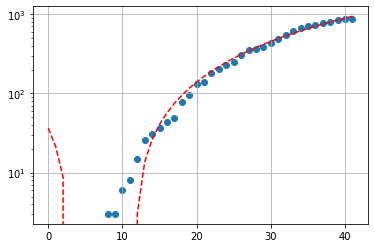

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 3.393
Total cases up to today: 667
New cases registered today: 8
New cases registered today in %: 1.21
Doubling time in the last five days: 20.0
Doubling time yesterday: 17.9
Trend of new cases (in %) in the last 5 days: 18.89


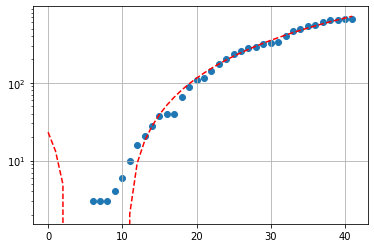

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.2896
Total cases up to today: 544
New cases registered today: 17
New cases registered today in %: 3.23
Doubling time in the last five days: 24.1
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 15.5


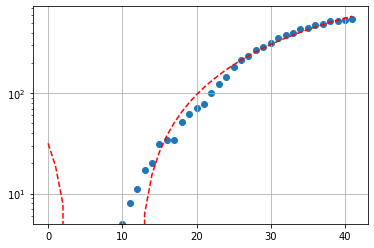

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.3501
Total cases up to today: 394
New cases registered today: 20
New cases registered today in %: 5.35
Doubling time in the last five days: 20.2
Doubling time yesterday: 24.1
Trend of new cases (in %) in the last 5 days: 18.67


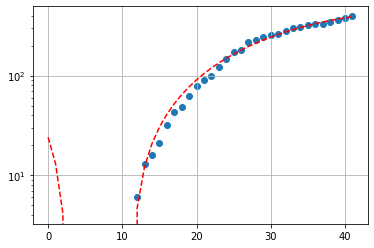

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.3275
Total cases up to today: 338
New cases registered today: 6
New cases registered today in %: 1.81
Doubling time in the last five days: 12.8
Doubling time yesterday: 11.9
Trend of new cases (in %) in the last 5 days: 31.01


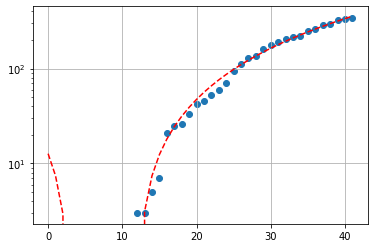

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.267
Total cases up to today: 340
New cases registered today: 1
New cases registered today in %: 0.29
Doubling time in the last five days: 28.4
Doubling time yesterday: 20.4
Trend of new cases (in %) in the last 5 days: 12.96


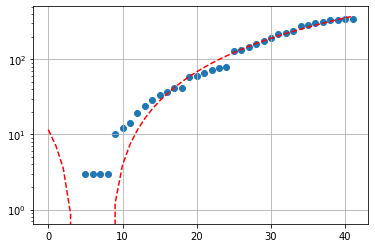

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 4.2424
Total cases up to today: 2285
New cases registered today: 65
New cases registered today in %: 2.93
Doubling time in the last five days: 12.9
Doubling time yesterday: 12.5
Trend of new cases (in %) in the last 5 days: 30.87


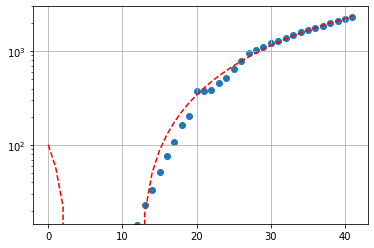

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1200
New cases registered today: 32
New cases registered today in %: 2.74
Doubling time in the last five days: 24.7
Doubling time yesterday: 25.2
Trend of new cases (in %) in the last 5 days: 15.05


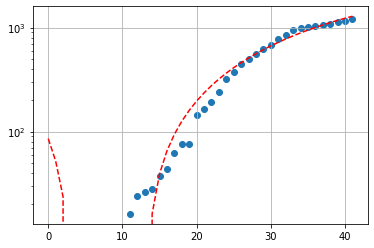

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.4001
Total cases up to today: 925
New cases registered today: 20
New cases registered today in %: 2.21
Doubling time in the last five days: 26.9
Doubling time yesterday: 26.0
Trend of new cases (in %) in the last 5 days: 13.78


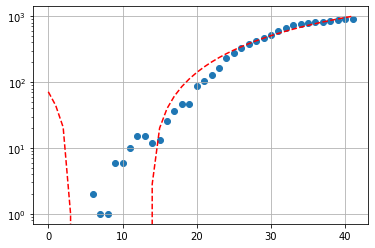

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.205
Total cases up to today: 275
New cases registered today: 12
New cases registered today in %: 4.56
Doubling time in the last five days: 19.4
Doubling time yesterday: 22.9
Trend of new cases (in %) in the last 5 days: 19.57


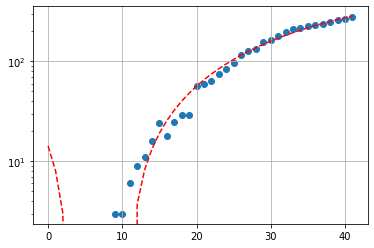

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 6.1632
Total cases up to today: 782
New cases registered today: 34
New cases registered today in %: 4.55
Doubling time in the last five days: 15.8
Doubling time yesterday: 14.0
Trend of new cases (in %) in the last 5 days: 24.52


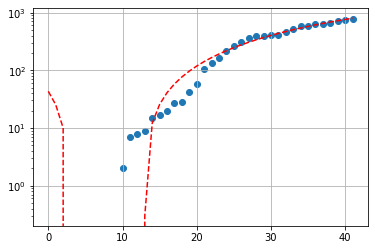

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 10940
New cases registered today: 398
New cases registered today in %: 3.78
Doubling time in the last five days: 16.6
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 23.25


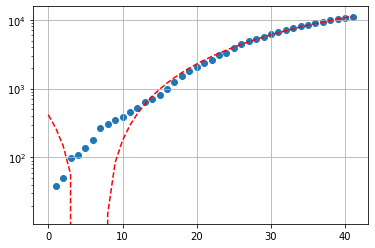

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 2.6144
Total cases up to today: 538
New cases registered today: 16
New cases registered today in %: 3.07
Doubling time in the last five days: 15.5
Doubling time yesterday: 16.5
Trend of new cases (in %) in the last 5 days: 25.12


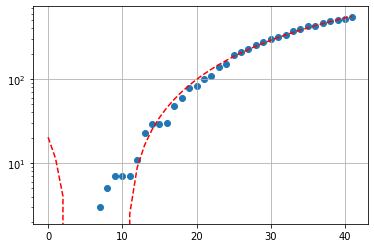

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.9308
Total cases up to today: 2744
New cases registered today: 112
New cases registered today in %: 4.26
Doubling time in the last five days: 18.0
Doubling time yesterday: 18.8
Trend of new cases (in %) in the last 5 days: 21.2


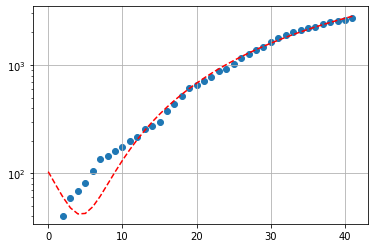

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.7796
Total cases up to today: 186
New cases registered today: 2
New cases registered today in %: 1.09
Doubling time in the last five days: 11.1
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 36.76


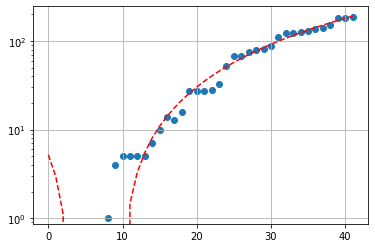

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.9323
Total cases up to today: 1712
New cases registered today: 25
New cases registered today in %: 1.48
Doubling time in the last five days: 29.5
Doubling time yesterday: 22.8
Trend of new cases (in %) in the last 5 days: 12.48


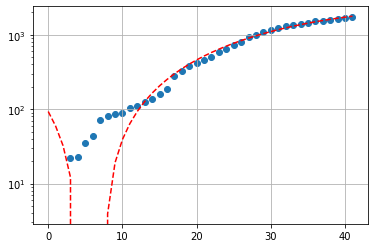

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.6681
Total cases up to today: 1425
New cases registered today: 63
New cases registered today in %: 4.63
Doubling time in the last five days: 17.6
Doubling time yesterday: 16.7
Trend of new cases (in %) in the last 5 days: 21.79


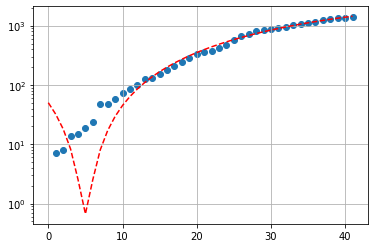

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.9168
Total cases up to today: 2688
New cases registered today: 141
New cases registered today in %: 5.54
Doubling time in the last five days: 14.4
Doubling time yesterday: 13.8
Trend of new cases (in %) in the last 5 days: 27.27


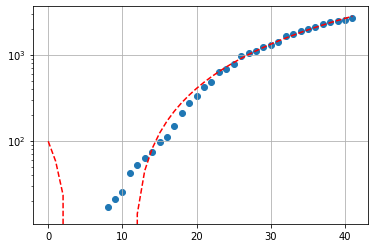

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.9039
Total cases up to today: 1647
New cases registered today: 39
New cases registered today in %: 2.43
Doubling time in the last five days: 12.3
Doubling time yesterday: 10.8
Trend of new cases (in %) in the last 5 days: 32.61


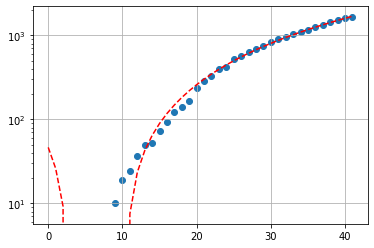

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')